In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tkinter as tk

stations = pd.read_csv("stations.csv")
routes = pd.read_csv("routes.csv")
lineColours = pd.read_csv("routeColours.csv")

In [2]:
stations.head()

,station,latitude,longitude
0,Neu-Westend,52.516101,13.260510
1,Senefelderplatz,52.532588,13.412608
2,Heidelberger Platz,52.480206,13.311837
3,Schwartzkopffstraße,52.535432,13.377004
4,Westhafen,52.536235,13.344020


In [3]:
stations.dtypes

station       object
latitude     float64
longitude    float64
dtype: object

In [4]:
routes.head()

,von,nach,linie
0,Hauptbahnhof,Bundestag,U5
1,Bundestag,Brandenburger Tor,U5
2,Brandenburger Tor,Unter den Linden,U5
3,Unter den Linden,Museumsinsel,U5
4,Museumsinsel,Rotes Rathaus,U5


## Plot Berlin U- and S-Bahn network
This will include route colours and will related to latitude and longitude points
repeated stations in stations.csv will have to be removed

In [5]:
G = nx.Graph()
for i, node in stations.iterrows():
    G.add_node(node["station"], pos=(node["longitude"], node["latitude"]))

for i, edge in routes.iterrows():
    # find edge colour
    routeName = edge.linie
    colourRow = lineColours[lineColours.route == routeName].iloc[0]
    rgbCol = (colourRow.r/255, colourRow.g/255, colourRow.b/255)

    # add edge to graph
    G.add_edge(edge["von"], edge["nach"], color=rgbCol)

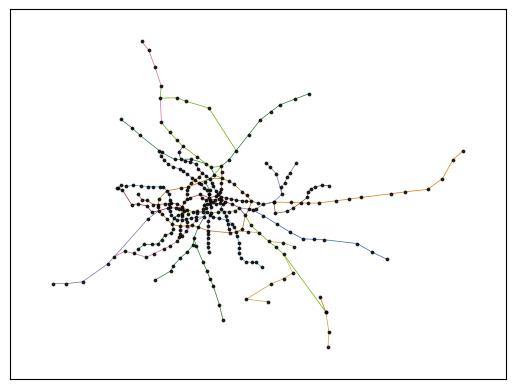

In [6]:
# plot nodes
pos = nx.get_node_attributes(G, "pos")
nx.draw_networkx_nodes(G, pos, node_size=3, node_color="black", alpha=0.8)

# plot edges and associated colours
edgeCols = list(nx.get_edge_attributes(G, "color").values())
nx.draw_networkx_edges(G, pos, edge_color=edgeCols, width=0.5, arrows=False)

## Plot Berlin network against a map


In [7]:
import folium
import webbrowser

# plot the map of berlin
m = folium.Map(tiles="cartodb positron", location=(52.52, 13.40), zoom_start=10)

# add markers for stations to the map
for index, station in stations.iterrows():
    location = [station["latitude"], station["longitude"]]
    folium.CircleMarker(location, radius=3,
                       popup = f"Name:{station["station"]}",
                       color="green",
                       fill_color="#000000",
                       fill_opacity=1.0,
                       weight=2).add_to(m)

# draw the connections between stations



for index, route in routes.iterrows():
    # get names of stations
    station1 = stations[stations.station==route["von"]]
    station2 = stations[stations.station==route["nach"]]
    
    # get coordinates of stations
    coords1 = [station1["latitude"].iloc[0], station1["longitude"].iloc[0]]
    coords2 = [station2["latitude"].iloc[0], station2["longitude"].iloc[0]]

    # get colour based on rail line
    line = route["linie"]
    lineColour = lineColours[lineColours.route==line]
    lineColourStr = "rgb("+str(lineColour.r.item())+", "+str(lineColour.g.item())+", "+str(lineColour.b.item())+")"
    #print(lineColourStr)

    # add line to map
    folium.PolyLine([coords1, coords2], color=lineColourStr, weight=2.5, opacity=0.8).add_to(m)
    

# save as webpage
m.save("map.html") #webbrowser.open("map.html")

# display map in jupyter
m

In the Jupyter Notebook on GitHub, this map will not be displayed properly. For this reason, an image of the map has been rendered here.

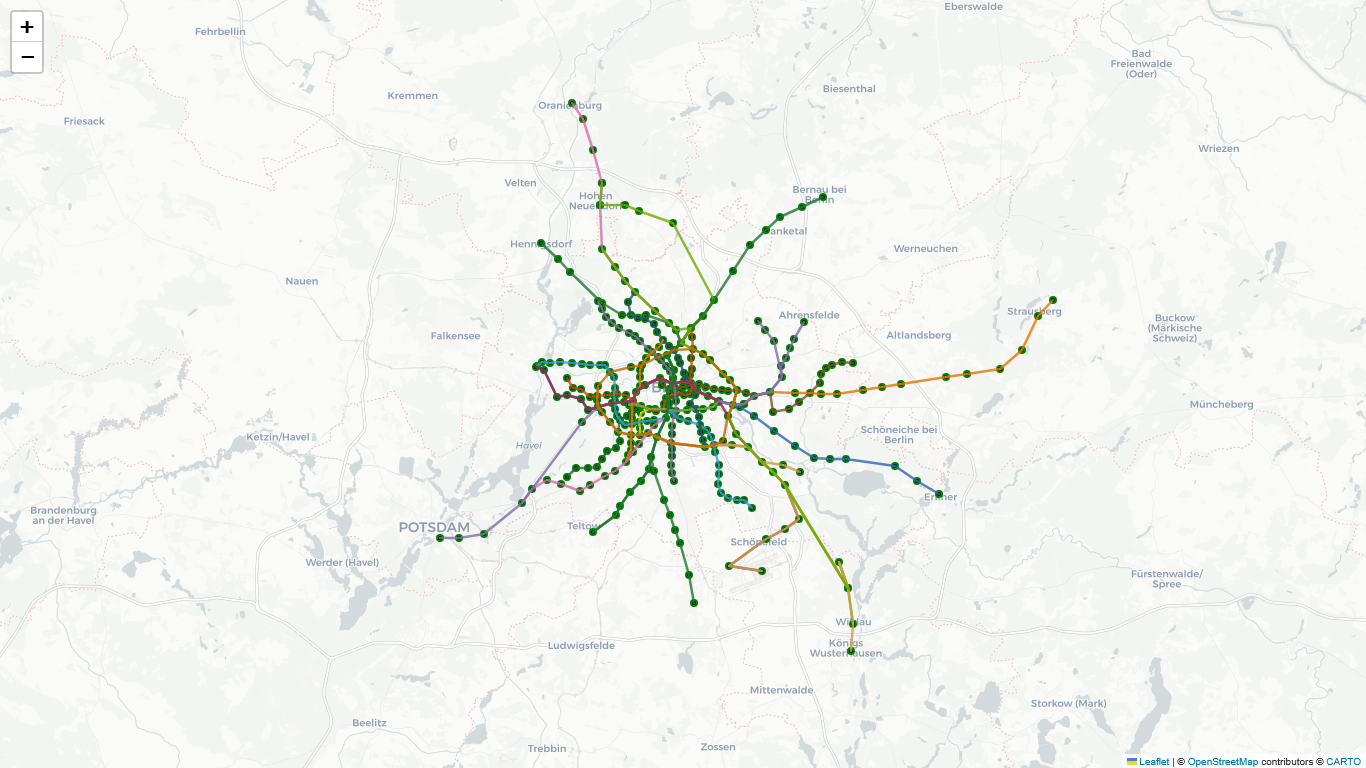

In [8]:
from PIL import Image
import io

# save and display map
img_data = m._to_png(5) # 5 second delay to let tiles load
img = Image.open(io.BytesIO(img_data))
img.save('berlinTransportNetwork.png')
img